# Intro
We are Ram (123) and Or (315339960), and in this notebook, we are going to talk about data from 911 calls. We have looked far and wide for a dataset that has enough "meat" for a nice EDA, in a field that is interesting to us, and we believe we found it in this [Kaggle Dataset](https://www.kaggle.com/datasets/louisteitelbaum/911-recordings-first-6-seconds).

911 is an emergency telephone number for North America. Analysing emergency calls dataset can lead to solutions that could potentially help 911 operators.


This dataset contains a collection of usunsual or critical calls, including the full audio version of them, and only the first 6 seconds of each call. It also has a .csv table which includes features like title, state, number of casualities, was this call a false alarm etc.
We found the subject matter to be exteremly interesting, as well as countless ways to interact with the data itself - from speech to text, using text embeddings on these texts, to use those embeddings to cluster calls... the ways of interacting with the data felt endless.

# The Problem
911 gets around 657,000 calls, every single day in the US. This means thousands upon thousands of operators are needed, and they must perform flawlessly for hunderds of calls each and every day, with the extreme pressure that if they make a mistake - it could cost someone's life.
Right now the operator has to sift through all of those calls, and try to understand if every one of the callers is in real danger or not. Also, in many instances, the caller who is in danger might not want to reveal he is talking to 911, so he could be talking in code. The operator must differentiate between those who are in danger, to those who mixed up 911 with Domino's number.

We propose to make a model that can make their lives easier in several ways. 
For one, it can also listen in to the call with the operator, and try to make suggestions, to determine whether or not to send a police car to the call's location. Also, it can be used to determine whether or not the call was a false alarm. 
It can serve as an assistant to the operator, to help them reduce the amount of mistakes they make.

# Dataset Preface

This dataset is skewed towards irregular calls, that is used to train 911 operators. To use this data to correctly make predictions about random 911 calls could lead to bad results because of it. Therefore we also need more regular 911 call data.

## Setup
Let's keep the imports and setup here:

In [2]:
# Some installtions here:
!pip install geopandas

In [3]:
# Imports and setup
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import YearLocator, DateFormatter
import itertools

sns.set_palette("pastel")
palette = itertools.cycle(sns.color_palette())



# EDA

First off, let's have a look at a sample of our data, so we can see the different columns that we have and examples of what they contain:

In [4]:
# load the dataset
df = pd.read_csv('911_metadata.csv')
print(f"total rows: {len(df)}")
df.sample(5)

total rows: 710


,id,event_id,link,title,date,state,deaths,potential_death,false_alarm,description,deaths_binary,break,filename
385,385,408,https://web.archive.org/web/20150417085338/htt...,Officer shooting,10/08,California,1.0,1.0,0.0,– In Oct. 2006 a Fresno (Calif.) man dialed 91...,1,17.0,911_first6sec/call_408_0.wav
92,92,107,https://web.archive.org/web/20150417085335/htt...,Out-of-control car,7/670,Hawaii,0.0,1.0,0.0,– In Dec. 2010 a driver on Molokai (Hawaii) di...,0,12.0,911_first6sec/call_107_0.wav
127,127,145,https://web.archive.org/web/20150417085334/htt...,Home invasion,5/11,Oklahoma,0.0,0.0,0.0,– In May 2011 three people invaded a Muskogee ...,0,3.0,911_first6sec/call_145_0.wav
327,327,349,https://web.archive.org/web/20150417085352/htt...,Bank robbery,12/13,Arizona,1.0,1.0,0.0,– In Dec. 2013 Mario Garnett went on a multi-s...,1,6.0,911_first6sec/call_349_0.wav
244,244,266,https://web.archive.org/web/20150417085340/htt...,Intruder shot,8/12,Washington,1.0,1.0,0.0,– In August 2012 a Clark County (Wash.) couple...,1,13.0,911_first6sec/call_266_0.wav


From this ~700 rows dataset, we have information about which state the call was made from, what month it happened in, was it a false alarm, how many people died as the result of the event (also available as a boolean), "break" - which is, how many seconds into the call the recording was made and a general title and description of what happened.
We also have the link to the original call audio file, which we will use later.

## Cleaning the data

Let's start by trying to deduplicate by the id field:

In [15]:
df_clean = df.drop_duplicates(subset=['id'])
print(f"total dataset count after deduplication: {len(df_clean)}")

total dataset count after deduplication: 710


It appears there are no duplications - however, let's also try to deduplicate by the "link" column, which should have unique values as the calls should be different:

In [16]:
df_clean = df.drop_duplicates(subset=['link'])
print(f"total dataset count after deduplication: {len(df_clean)}")

total dataset count after deduplication: 644


So, it seems like there are duplicates after all - let's see an example of a duplicate to see if there is anything we can learn from them:

In [18]:
dup_vc = df.value_counts(['link'])
print(dup_vc)

link                                                                                                                  
https://web.archive.org/web/20150417085348/http://mp3.911dispatch.com.s3.amazonaws.com/murfreesboro_tornado_911.mp3       7
https://web.archive.org/web/20150417085342/http://mp3.911dispatch.com.s3.amazonaws.com/non_emerg_911s.mp3                 6
https://web.archive.org/web/20150417085349/http://mp3.911dispatch.com.s3.amazonaws.com/west_explosion_911.mp3             6
https://web.archive.org/web/20150417085351/http://mp3.911dispatch.com.s3.amazonaws.com/jerseycity_af1_911.mp3             4
https://web.archive.org/web/20150417085349/http://pdf.911dispatch.com.s3.amazonaws.com/clackamas_mall_shooting_911.mp3    4
                                                                                                                         ..
https://web.archive.org/web/20150417085338/http://www.911dispatch.com/reference/fortwayne_burglary_911.mp3                1
https://web.a

Let's look at the entries for the top link:

In [19]:
df[df['link'] == 'https://web.archive.org/web/20150417085348/http://mp3.911dispatch.com.s3.amazonaws.com/murfreesboro_tornado_911.mp3']

,id,event_id,link,title,date,state,deaths,potential_death,false_alarm,description,deaths_binary,break,filename
511,511,552,https://web.archive.org/web/20150417085348/htt...,Tornado strike,4/09,Tennessee,2.0,1.0,0.0,– In April 2009 a tornado struck Murfreesbobo ...,1,11.000,911_first6sec/call_552_0.wav
512,512,552,https://web.archive.org/web/20150417085348/htt...,Tornado strike,4/09,Tennessee,2.0,1.0,0.0,– In April 2009 a tornado struck Murfreesbobo ...,1,48.000,911_first6sec/call_552_1.wav
513,513,552,https://web.archive.org/web/20150417085348/htt...,Tornado strike,4/09,Tennessee,2.0,1.0,0.0,– In April 2009 a tornado struck Murfreesbobo ...,1,75.000,911_first6sec/call_552_2.wav
514,514,552,https://web.archive.org/web/20150417085348/htt...,Tornado strike,4/09,Tennessee,2.0,1.0,0.0,– In April 2009 a tornado struck Murfreesbobo ...,1,138.000,911_first6sec/call_552_3.wav
515,515,552,https://web.archive.org/web/20150417085348/htt...,Tornado strike,4/09,Tennessee,2.0,1.0,0.0,– In April 2009 a tornado struck Murfreesbobo ...,1,195.000,911_first6sec/call_552_4.wav
516,516,552,https://web.archive.org/web/20150417085348/htt...,Tornado strike,4/09,Tennessee,2.0,1.0,0.0,– In April 2009 a tornado struck Murfreesbobo ...,1,215.228,911_first6sec/call_552_5.wav
517,517,552,https://web.archive.org/web/20150417085348/htt...,Tornado strike,4/09,Tennessee,2.0,1.0,0.0,– In April 2009 a tornado struck Murfreesbobo ...,1,250.000,911_first6sec/call_552_6.wav


The only difference between entries was the 'break' column, which is the second at which the 6-second sample from the call has started. In other words - we have several timestamps from the call. We will need to take this into account when training our model.

Let's continue with the data cleaning process - Looking at the above sample, it appears "4/09" was used for April 2009. so we have month-granularity dates, but the format is not a valid python datetime format. let's add a leading zero to make this a datetime compatible format:

In [24]:

# Transform the date from string to datetime
def add_leading_zero(date_str):
    if date_str is None:
        return ''
    if len(date_str) < 5:
        return '0' + date_str
    else:
        return date_str

# Apply the function add_leading_zero to the 'date' column to make sure it starts with a 0
df_clean['date_dt'] = pd.to_datetime(df['date'].astype(str).apply(add_leading_zero), format='%m/%y', errors='coerce')
df_clean['date_dt']

C:\Users\orche\AppData\Local\Temp\ipykernel_22892\1933772912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['date_dt'] = pd.to_datetime(df['date'].astype(str).apply(add_leading_zero), format='%m/%y', errors='coerce')


0     2006-02-01
1     2005-03-01
2     2005-04-01
3     2005-01-01
4     2006-01-01
         ...    
705   2010-08-01
706   2010-08-01
707   2010-08-01
708   2010-08-01
709   2010-09-01
Name: date_dt, Length: 644, dtype: datetime64[ns]

Let's also convert all boolean columns to boolean values:

In [28]:
dfc = df.copy()
# Transform binaries to booleans
df_clean['false_alarm'] = dfc['false_alarm'].replace({1: True, 0: False})
df_clean['potential_death'] = dfc['potential_death'].replace({1: True, 0: False})
df_clean['deaths_binary'] = dfc['deaths_binary'].replace({1: True, 0: False})


C:\Users\orche\AppData\Local\Temp\ipykernel_22892\651638602.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['false_alarm'] = dfc['false_alarm'].replace({1: True, 0: False})
C:\Users\orche\AppData\Local\Temp\ipykernel_22892\651638602.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['potential_death'] = dfc['potential_death'].replace({1: True, 0: False})
C:\Users\orche\AppData\Local\Temp\ipykernel_22892\651638602.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

## Familiarizing ourselves with the data
As we can see, we have data about which state in the U.S. the call was made from. Let's plot this on a map of the US to get a picture of possible hot spots:

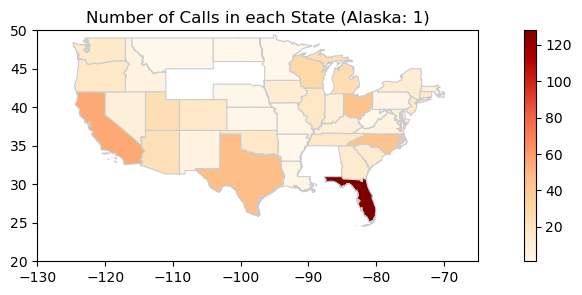

In [7]:
# Let's break it down by state
state_counts = df['state'].value_counts().reset_index()
state_counts.columns = ['state', 'count']
us_states = gpd.read_file('cb_2018_us_state_500k.shp')
us_states = us_states.merge(state_counts, left_on='NAME', right_on='state', how='left')
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
us_states.plot(column='count', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title(f"Number of Calls in each State (Alaska: {state_counts[state_counts['state'] == 'Alaska']['count'].values[0]})")
ax.set_xlim(-130,-65)
ax.set_ylim(20,50)
plt.show()


Florida, California, and Texas seem to lead, though it's no wonder considering the amount of people within these states, though in general the data seems pretty well distributes. Let's try to find out the state with the most calls per 1M people:

(20.0, 50.0)

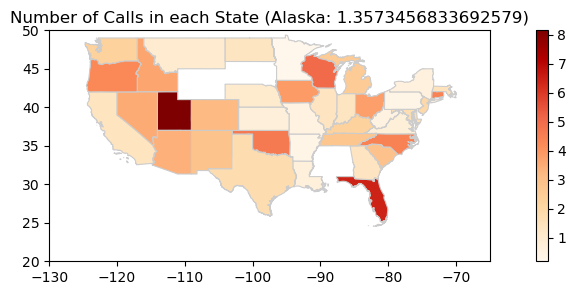

In [8]:
state_csv = pd.read_csv('https://gist.githubusercontent.com/bradoyler/0fd473541083cfa9ea6b5da57b08461c/raw/fa5f59ff1ce7ad9ff792e223b9ac05c564b7c0fe/us-state-populations.csv')
us_states_with_pop = us_states.merge(state_csv, left_on='STUSPS', right_on='code', how='left')
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
us_states_with_pop['calls_per_1M'] = (us_states_with_pop['count'] / us_states_with_pop['pop_2014']) * 1000000
us_states_with_pop.plot(column='calls_per_1M', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title(f"Number of Calls in each State (Alaska: {us_states_with_pop[us_states_with_pop['NAME'] == 'Alaska']['calls_per_1M'].values[0]})")
ax.set_xlim(-130,-65)
ax.set_ylim(20,50)

So if we needed to answer which state has the most troublesome average citizen, seems like Utah takes the cake with florida coming to a close second.

Next, let's take a look at the false alarm column, to figure out how much data tagged as false alarm do we have:

<Figure size 800x600 with 0 Axes>

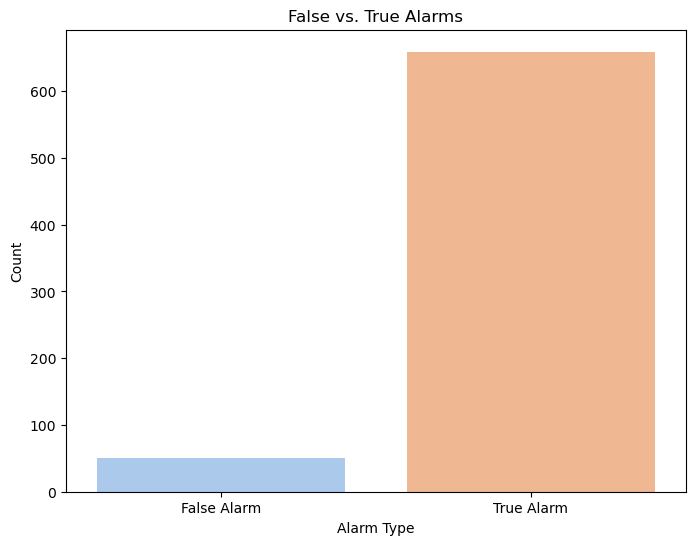

In [9]:
# Let's make a false alarm plot
# Count the number of false and true alarms
true_alarm_count = df_clean[df_clean['false_alarm'] == False]['id'].count()
false_alarm_count = df_clean[df_clean['false_alarm'] == True]['id'].count()

# Create a bar chart
plt.figure(figsize=(8, 6))

# Create a bar chart using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=['False Alarm', 'True Alarm'], y=[false_alarm_count, true_alarm_count])
plt.xlabel('Alarm Type')
plt.ylabel('Count')
plt.title('False vs. True Alarms')
plt.show()


Let's also look at how many calls resulted in deaths:

In [ ]:
no_deaths_count = df_clean[df_clean['deaths_binary'] == False]['id'].count()
deaths_count = df_clean[df_clean['deaths_binary'] == True]['id'].count()

# Create a bar chart
plt.figure(figsize=(8, 6))

# Create a bar chart using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=['No Deaths', 'Deaths'], y=[no_deaths_count, deaths_count])
plt.xlabel('Alarm Type')
plt.ylabel('Count')
plt.title('False vs. True Alarms')
plt.show()


potential_death  False  True 
deaths_binary                
False               87    202
True                13    407


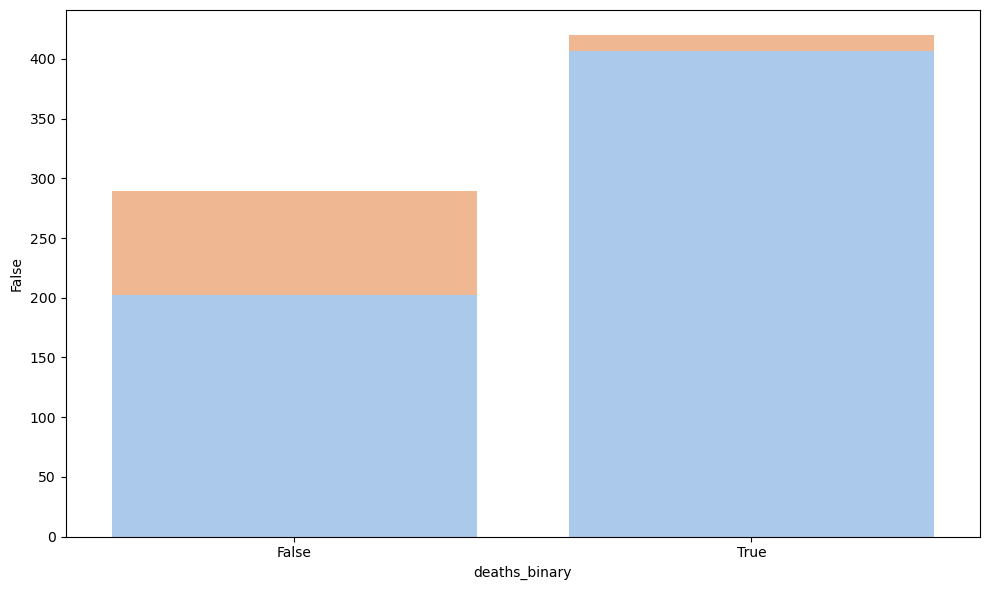

In [ ]:
# Group the data by 'deaths_bool' and 'potential_deaths' columns and count the occurrences
grouped_data = df_clean.groupby(['deaths_binary', 'potential_death'])['id'].count().unstack()
print(grouped_data)
# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_data.reset_index(), x='deaths_binary', y=True, color=next(palette), label='Potential Death')
sns.barplot(data=grouped_data.reset_index(), x='deaths_binary', y=False, color=next(palette), label='Not Potential Death', bottom=grouped_data[True])

ax.set_xlabel('Potential Deaths')
ax.set_ylabel('Count')
ax.set_title('Cases with Potential Deaths and Outcomes')
ax.legend(title='Death Occurred', labels=['No', 'Yes'], loc='upper right')

plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.tight_layout()
plt.show()

Seems like the vast majority of the calls were not, in fact, false alarms. Which could pose a problem if we were to try and detect whether or not a call was a false alarm with our model.

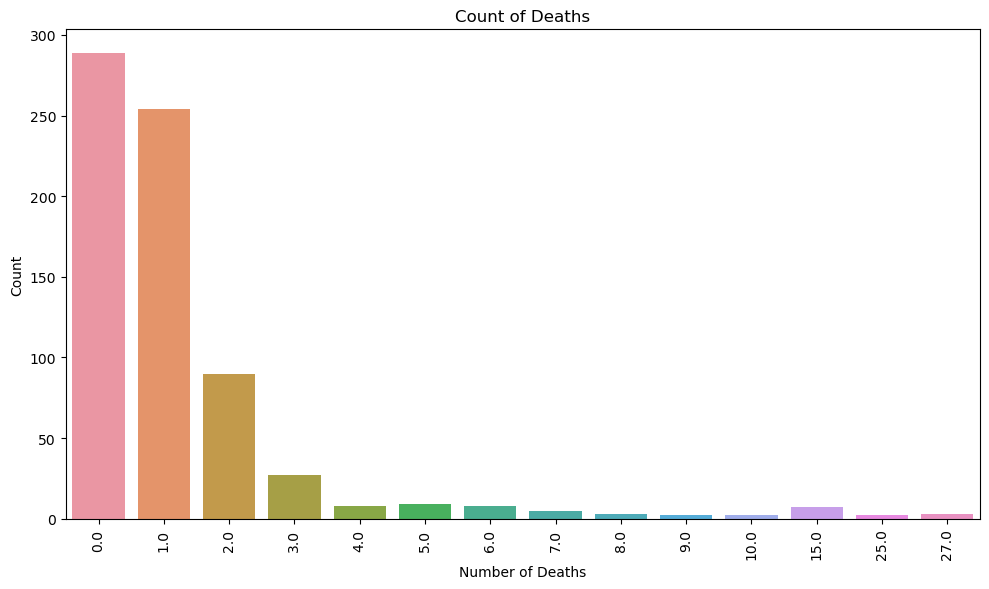

In [10]:
# Create a count plot of the 'deaths' column
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='deaths')
plt.xlabel('Number of Deaths')
plt.ylabel('Count')
plt.title('Count of Deaths')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


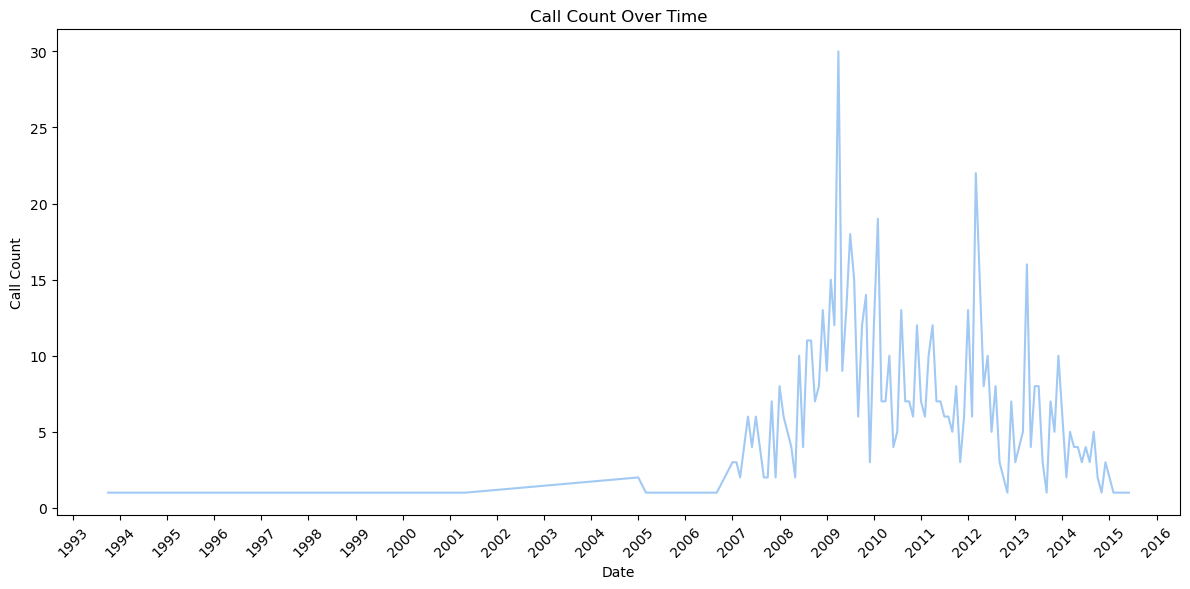

In [11]:
# Group the data by date and count the calls for each date
calls_by_date = df_clean.groupby('date_dt')['id'].count().reset_index()
years_locator = YearLocator(base=1)
years_format = DateFormatter('%Y')


# Create a line chart
plt.figure(figsize=(12, 6))
sns.lineplot(data=calls_by_date, x='date_dt', y='id')

plt.gca().xaxis.set_major_locator(years_locator)
plt.gca().xaxis.set_major_formatter(years_format)

plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel('Call Count')
plt.title('Call Count Over Time')
plt.tight_layout()
plt.show()


Another attribute we have is the "break" column, which tells us how long into the call the audio snippet begins. Let's see it plotted:

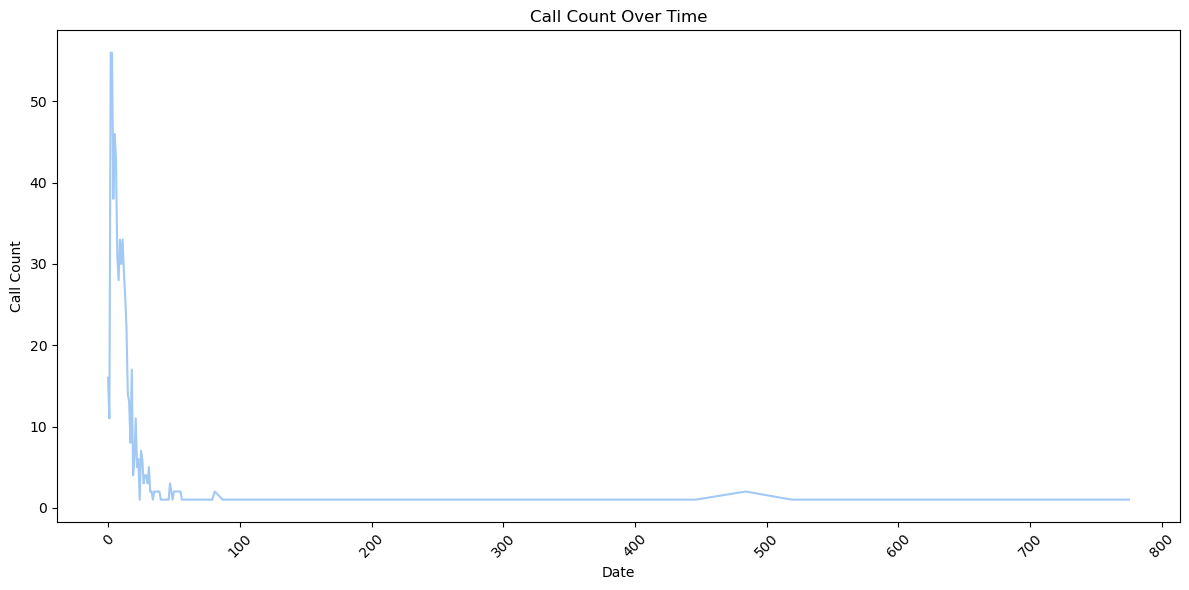

In [13]:
# Group the data by date and count the calls for each date
calls_by_break = df_clean.groupby('break')['id'].count().reset_index()

# Create a line chart
plt.figure(figsize=(12, 6))
sns.lineplot(data=calls_by_break, x='break', y='id')

plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel('Call Count')
plt.title('Call Count Over Time')
plt.tight_layout()
plt.show()


So while the vast majority of calls are from the very beginning of the call, some aren't. We should keep this in mind in case our model will assume the calls are actually the first 6 seconds, as the name of the dataset suggests.